In [1]:
! nvidia-smi

Fri Feb 18 11:28:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
|  0%   42C    P2    56W / 250W |   8444MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:5E:00.0 Off |                  N/A |
|  0%   

In [2]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import datetime as datetime
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warp_Flow
from utils.encoding import labelMatrixOneHot, dice_coeff
import torch.utils.checkpoint
from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7ff0f841c5b0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

# Data

In [3]:
imgs = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

test_imgs = torch.load('/share/data_ultraschall/nicke_ma/data/test_frames_disp_6.pth')
test_segs = torch.load('/share/data_ultraschall/nicke_ma/data/test_segs_disp_6.pth')

train_set = torch.arange(len(imgs))
test_set = torch.arange(len(test_imgs))

# Model

In [300]:
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                 (1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2).cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2).cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                (1, 1, grid_size, grid_size)).view(1, -1, 1,
                                                                   2).cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1 = F.relu(self.batch2(self.layer2(x_1)))
        features_fixed = self.layer3(x_1)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2 = F.relu(self.batch2(self.layer2(x_2)))
        features_moving = self.layer3(x_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return soft_cost, disp_xy


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, displace_range ** 2, H, W)

        return ssd_distance


class PDD2D(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(PDD2D, self).__init__()
        
        self.feat_extractor = OBELISK2d(chan)
        path_to_state_dict = f'models/Experiment_2/fineTuneSoft/soft_trained_17-02.pth'
        self.feat_extractor.load_state_dict(torch.load(path_to_state_dict))
        self.feat_extractor.cuda()

        H = size[0]
        W = size[1]
        
        self.identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
        
       
        self.refinement = nn.Sequential(nn.Conv2d(1,3,1),
                                        nn.BatchNorm2d(3),
                                        nn.ReLU(),
                                        nn.Conv2d(3,3,1),
                                        nn.BatchNorm2d(3),
                                        nn.ReLU(),
                                        nn.Conv2d(3,3,1),
                                        nn.Softmax(dim=1))
        

    def forward(self, fixed_img, moving_img, fixed_seg):
       
        soft_cost,disp_xy = self.feat_extractor(moving.cuda(), fixed.cuda())
        
        # warping step
        displacement = F.interpolate(disp_xy, size=(150,150), mode='bicubic')
        warped_seg = F.grid_sample(fixed_seg.unsqueeze(0).float(), self.identity+displacement.permute(0,2,3,1), mode='nearest', align_corners=False)
        
        onehot = F.one_hot(warped_seg.squeeze().long(), num_classes = 3).float().view(1,-1,H,W)
        #one_hotWarp = F.one_hot(warps.to(torch.int64), num_classes=- 1).transpose(4, 1).squeeze(4).cuda()*0.8
        
        refine_in = torch.cat((displacement, onehot.view(1,-1,H,W)), axis=1)
        refine_output = self.refinement(onehot)
        
        
        return refine_output


In [301]:
disp_hw = 5
displace_range = 11
label_weights = torch.tensor([0.1,0.6, 0.3])# weights for background = 0.1, Vein = 0.6 and Artery = 0.3
epochs = 100
lr = 0.0005

H=150;W=150

model = PDD2D()
for param in model.feat_extractor.parameters():
    param.requires_grad = False

model.train().cuda()

optimizer = torch.optim.Adam(list(model.refinement.parameters()),lr=lr)

In [302]:
losses = []
accs = []
unwarped = []
for epoch in trange(epochs, desc='epoch Loop', leave=False):
    model.train()
    # Shuffle Data
    #train_set_perm = torch.randperm(len(train_set))
    #train_set = train_set[train_set_perm]
    # show all examples to model
    for i in trange(2, desc='Train Loop', leave=False):
        
        rnd_idx = train_set[i]
        p_fix = train_set[rnd_idx]
        tmp_loss = torch.zeros(2)

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2

            
        pred = model(moving.cuda(), fixed.cuda(), fixed_seg.cuda()).cpu()
        moving_onehot = F.one_hot(moving_seg.long(), num_classes=3).float()
                
        loss = torch.sum(torch.pow(pred.view(3,-1) - moving_onehot.view(3,-1),2), axis=1).mean()        
        loss.backward()
        tmp_loss[i] = loss.item()
        
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(tmp_loss.mean().item())   
    tmp_acc = []
    for j in trange(2, desc="Eval loop", leave=False):
        p_fix = train_set[j]
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float() 
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2
        
        pred = model(moving.cuda(), fixed.cuda(), fixed_seg.cuda()).cpu()
        pred_soft = F.softmax(pred.detach(), dim=1)
        img = pred_soft.argmax(dim=1)
        
        d0 = dice_coeff(img,moving_seg,3)
        tmp_acc.append(d0.mean().item())
    accs.append(np.mean(tmp_acc))

epoch Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/2 [00:00<?, ?it/s]

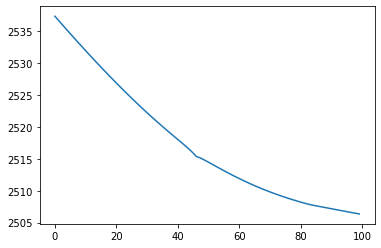

In [303]:
plt.plot(np.arange(epochs), losses)

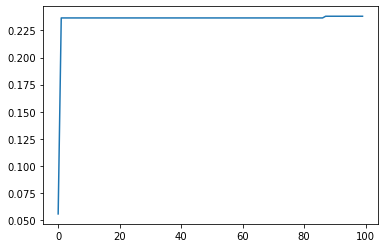

In [304]:
plt.plot(np.arange(epochs), accs)

In [305]:
pred_soft = F.softmax(pred.detach(), dim=1)
img = pred_soft.argmax(dim=1)

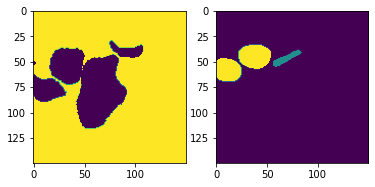

In [306]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img.view(H,W,-1))
ax[1].imshow(moving_seg.view(H,W,-1))

In [ ]:
dice_coeff(img,moving_seg,3)